# Applying Complex Orthogonal Decomposition to Lampreys swimming in fluid environment of various viscosity
# Part IV - Second mode
## In this notebook, we look in detail at the second complex orthogonal mode
### Author: Yuexia Luna Lin (luna.lin@epfl.ch)
### Data provided by Prof. Eric Tytell.

# Start by loading some necessary libraries and our pre-processed dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import zipfile

import os
from os import listdir
from os.path import isfile, isdir, join
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.fft import rfft, irfft
from scipy.linalg import eigh
from scipy.optimize import curve_fit, brute, minimize

# The following two lines is to be able toeasily convert
# comma decimal place to point decimal place
import locale
locale.setlocale(locale.LC_NUMERIC, "fr_CH.ISO8859-15")
import time

# To read Eric's h5 file, we can't use Pandas since it requires a particular structure within the HDF5 file.
# So we need this library
import h5py

#%matplotlib inline
%matplotlib notebook

# Read in the pre-processed dataset

In [2]:
# We read in the pre-processed dataset
data_frame = pd.read_hdf("../Data/processed_midline_all.h5")

In [3]:
data_frame.head(30)

,filename,date,indiv,trial,t,frame,point,mxmm,mymm,viscosity,...,bodyaxisy,bodycoordx,bodycoordy,swimvelx,swimvely,swimvel,theta,d_theta,com_vel_theta,com_vel_d_theta
0,1,15868,1,1,0.58,0,1,341.299771,88.110667,1,...,-0.311522,73.796770,-7.270154,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
1,1,15868,1,1,0.58,0,2,349.324554,90.105424,1,...,-0.311522,65.549898,-6.665755,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
2,1,15868,1,1,0.58,0,3,357.545449,91.064575,1,...,-0.311522,57.439287,-5.016190,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
3,1,15868,1,1,0.58,0,4,365.759349,91.948042,1,...,-0.311522,49.358900,-3.296886,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
4,1,15868,1,1,0.58,0,5,374.046024,91.781670,1,...,-0.311522,41.536407,-0.557311,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
5,1,15868,1,1,0.58,0,6,382.245394,90.914370,1,...,-0.311522,34.015228,2.821113,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
6,1,15868,1,1,0.58,0,7,390.329370,89.114436,1,...,-0.311522,26.894238,7.049815,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
7,1,15868,1,1,0.58,0,8,398.584686,88.492048,1,...,-0.311522,19.243602,10.212945,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
8,1,15868,1,1,0.58,0,9,406.743469,89.811668,1,...,-0.311522,11.079718,11.500629,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
9,1,15868,1,1,0.58,0,10,414.012944,93.737974,1,...,-0.311522,2.948849,10.034300,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216


# We still need the functions from Part II to extract body position data, perform COD, etc. We copy and paste here, but these functions can be save as a separate module, to be imported like any python module

In [4]:
def extract_single_trial_bodyframe(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the frame where COM is at the origin, and the body axis align with x axis.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    # For each body part, average the bodycoordinate (this only works)
    # if we have projected to bodyframe and fixed the origin at COM
    xdata = np.array([df.loc[df['point'] == i, 'bodycoordx'].mean() for i in bodyparts])
    
    ydata = np.empty([num_frames, len(bodyparts)])
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'bodycoordy'].values
        
    return xdata, ydata

def extract_single_trial(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the lab frame.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    ydata = np.empty([num_frames, num_parts])
    xdata = np.empty_like(ydata)
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'mymm'].values
        xdata[fr] =  df.iloc[start:finish].loc[:,'mxmm'].values
    return xdata, ydata

In [5]:
# We pass in the real signals
# Organized as: each row represent the whole fish (N body parts) at a time point
def complex_orthog_decomp(real_signal, tf_type=None, dc_type=None):
    """ This function performs COD on real signal, by first complexifying it,
    then decomposing the complex correlation matrix."""
    
    nf = real_signal.shape[0]
    zdata = np.empty_like(real_signal)
    
    if tf_type == None or tf_type == 'FFT':
        # Transform the time series at each sensor location into complex signal
        # See https://en.wikipedia.org/wiki/Analytic_signal
        
        ffty = np.fft.fft(real_signal, axis=0)
        freq = np.fft.fftfreq(nf)
        ffty[freq>0, :] = 2*ffty[freq>0, :]
        ffty[freq<0, :] = 0
        zdata = np.fft.ifft(ffty, axis=0)
        #print(zdata.shape)

    elif tf_type == 'H':

    # According to scipy documentation, hilbert transform output x_a(t) = x(t) + iy(t),
    # which is the complex signal COD calls for (Feeny, 2008)
    # We transform along column direction, axis=0, since each row represents a time point
        zdata = hilbert (real_signal, axis=0)
    
    else: 
        print("Transformation type can either be Fourier Transform (FFT) or Hilbert Transform (H).")
        print("Default is FFT.")
        
    # Cast the ndarray zdata to matrix for convenience
    # The complex ensemble matrix is organized as follows:
    # each row is a time series of signal at a given sensor.
    # In the fish example, in each row we have the time series of a body part
    Z = np.asmatrix(zdata).T

    # Assemble the complex correlation matrix
    R = 1./nf * (Z @ (Z.H))

    #print("Check complex correlation matrix is Hermitian norm(R-R.H): ", np.linalg.norm(R-R.H))
    
    num_samples = real_signal.shape[1]
    U = np.zeros([num_samples, num_samples])
    S = np.zeros(num_samples)
    Vh = np.empty_like(U)
    if dc_type == 'eig':
        # Compute the eigenvalues and eigenvectors of the correlation matrix
        # Using eigen decomposition
        S, U = np.linalg.eigh(R)
        S = np.flip(S)
        U = np.flip(U, axis=1)
        
    elif dc_type == None or dc_type == 'svd':
        # Since R is Hermitian (complex conjugate symmetric)
        # its SVD is just eigen decoposition
        U, S, Vh = np.linalg.svd(R)
        
    else: 
        print("Decomposition type can either be eigen 'eig' or SVD 'svd'.")
        print("Default is SVD.")

        
    return zdata, Z, R, S, U

# Use the real and imaginary part of the eigenmodes to compute traveling index
def traveling_index(U):
    """ This function computes the traveling index for every complex orthogonal mode."""
    
    # The number of traveling indices is the number of modes (columns in eigenvector matrix)
    tr_ind = np.zeros(U.shape[1])

    # For each mode, we create a rectangular matrix with columns being the real and imag part of the mode
    # The traveling index is the inverse of the condition number of this matrix
    for i in range(len(tr_ind)):
        tmp = np.concatenate( (np.real (U[:, i]).reshape(-1,1) , np.imag(U[:, i]).reshape(-1,1)), axis=1)
        cond = np.linalg.cond(tmp)
        tr_ind[i] = 1./cond
        
    return tr_ind

# Additionally, we will be using some functions to help with analyzing the second mode
- frequency filters (low band, high band)
- correlation functions (defined as minus correlation coefficient, since the optimizer we use from scipy minimizes a function)

In [6]:
def low_band_filter(series, dt, thres):
    """ Threshold frequency included in the result. Only take 1D array."""
    series = series.flatten()
    fsignal = np.fft.fft(series)
    freq = np.fft.fftfreq(len(series), d = dt)
    fsignal[np.abs(freq)>thres] = 0
    return np.real(np.fft.ifft(fsignal))

def mid_band_filter(series, dt, thres_low, thres_high):
    """ Lower threshold included, while upper thershold excluded, in the result. Only take 1D array."""
    series = series.flatten()
    fsignal = np.fft.fft(series)
    freq = np.fft.fftfreq(len(series), d = dt)
    fsignal[np.abs(freq)<thres_low] = 0
    fsignal[np.abs(freq)>=thres_high] = 0
    print("Non zero frequncies:", np.sum(fsignal!=0))
    return np.real(np.fft.ifft(fsignal))


In [7]:
def minus_corrFunc (lag,a,b):
    result = np.zeros_like(lag, dtype=float)
    for i, x in zip(range(len(lag)), np.array(lag,dtype=int)):
        TmpObs = np.vstack([np.roll(a,x), b])
        C = np.cov(TmpObs)
        result[i]=-(C[0,1])/np.sqrt(C[0,0]*C[1,1])
    return result

# First we visualize the heading angle of the longest trial in 3x water viscosity, as an example

<IPython.core.display.Javascript object>


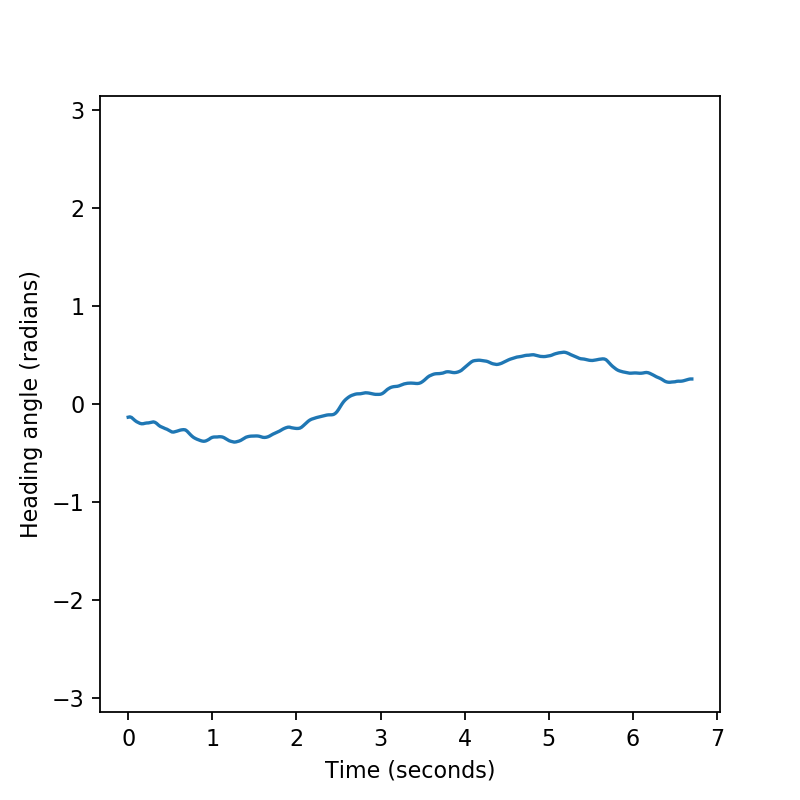

Text(0, 0.5, 'Heading angle (radians)')

In [8]:
# We pick this individual because the swim time is long, we have more data of it actually turning its heading direction
v = 3
ind = 4
tr = 29

trial_df = data_frame.loc[(data_frame['indiv'] == ind) &\
                          (data_frame['trial'] == tr)].copy()



frames = np.array(trial_df.loc[:,'frame'].unique()).copy()
time = frames * 0.02
theta = np.array(trial_df.loc[trial_df['point'] == 1, 'theta'], dtype='float')

plt.figure(figsize=(5,5))
plt.plot(time, theta)
plt.ylim([-np.pi, np.pi])
plt.xlabel('Time (seconds)')
plt.ylabel('Heading angle (radians)')

# Now we look at the time coefficients (complex orthogonal coordinates or COC) of second mode (and the 1st and 3rd) to see if we can attribute directional change to it

Linear trends in COC of forward mode:  [[-2.96034617]
 [10.82333797]]
Linear trends in COC of steer mode:  [[-2.08367173]
 [ 9.98085974]]
Linear trends in COC of backward mode:  [[0.05241434]
 [0.44842204]]


<IPython.core.display.Javascript object>


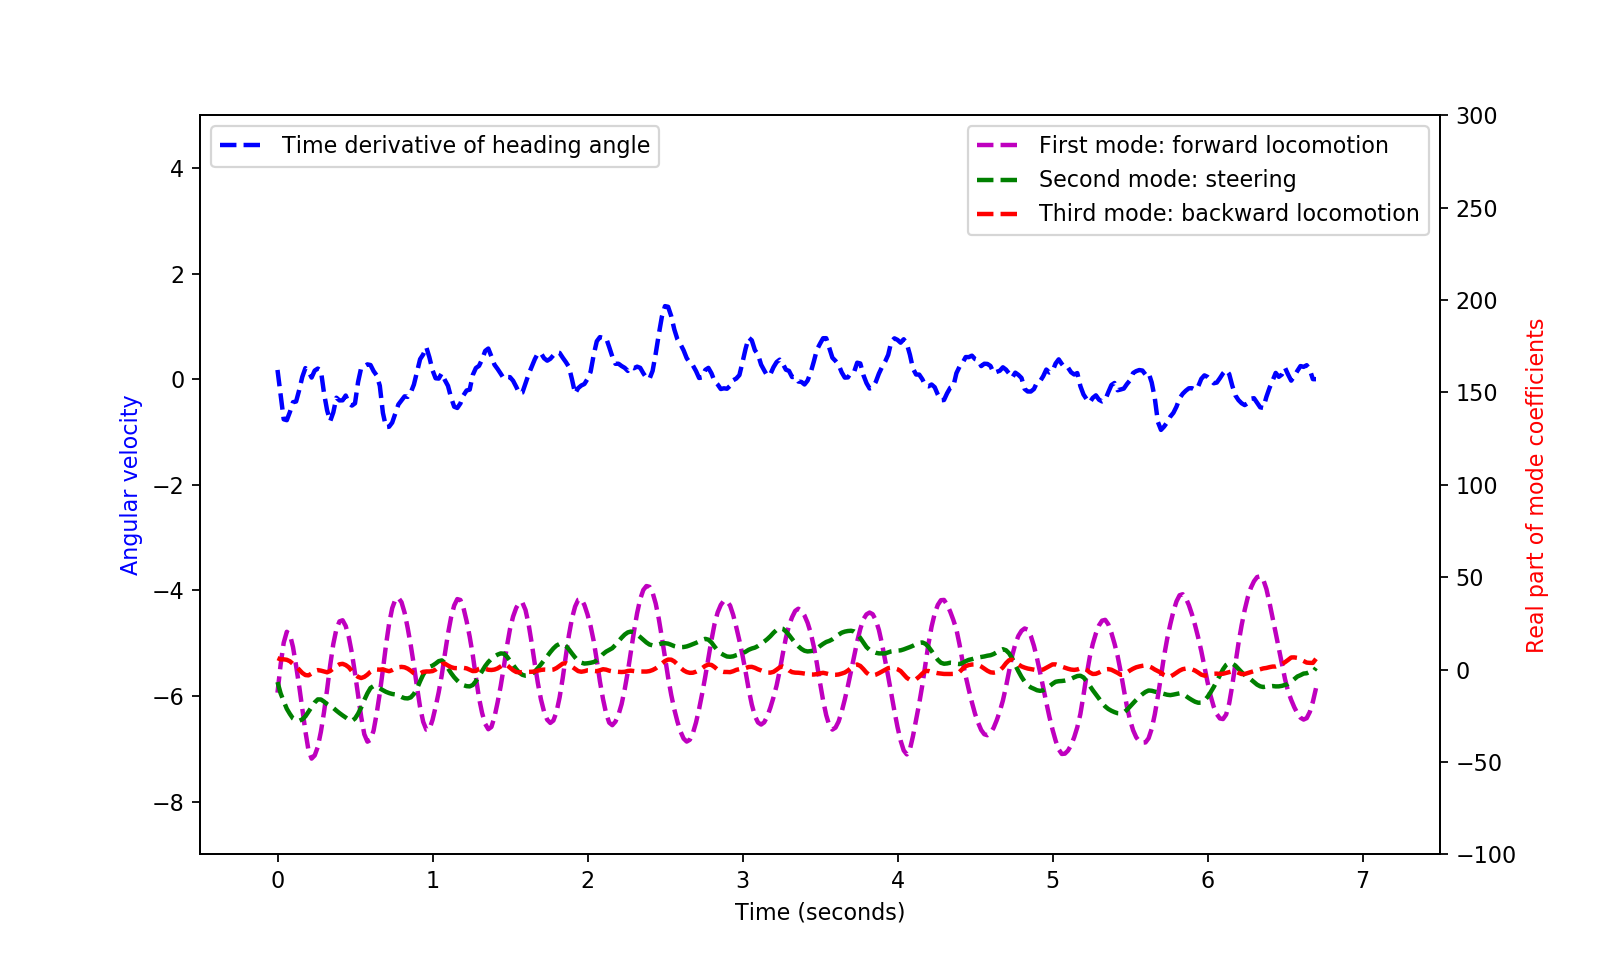

In [9]:
xdata, ydata = extract_single_trial_bodyframe(trial_df)
zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')
Q = U.H @ Z

# We make life easier by making some alias of the quantities we need and cast them into ndarrays
dtheta = np.array(trial_df.loc[trial_df['point']==1, 'd_theta'], dtype='float').reshape(-1,1)
num_frames = len(dtheta)

Q_of_loco = np.array(np.real(Q[0,:]).reshape(-1,1), dtype = 'float')
Q_of_steer = np.array(np.real(Q[1,:]).reshape(-1,1), dtype = 'float')
Q_of_back = np.array(np.real(Q[2,:]).reshape(-1,1), dtype = 'float')

tmpA = np.vstack([time, np.ones_like(time)]).T

# Here we subtract the linear trend in the time coefficient of mode 1
soln, res, rank, sv = np.linalg.lstsq(tmpA, Q_of_loco, rcond=None)
print("Linear trends in COC of forward mode: ", soln)
Q_of_loco = Q_of_loco-tmpA @ soln


# Here we subtract the linear trend in the time coefficient of mode 2
soln, res, rank, sv = np.linalg.lstsq(tmpA, Q_of_steer, rcond=None)
print("Linear trends in COC of steer mode: ", soln)
Q_of_steer = Q_of_steer-tmpA @ soln



# Here we subtract the linear trend in the coefficient of mode 3
soln, res, rank, sv = np.linalg.lstsq(tmpA, Q_of_back, rcond=None)
print("Linear trends in COC of backward mode: ", soln)
Q_of_back = Q_of_back-tmpA @ soln



# Plot the change in heading angle, and the coefficients of mode 2
fig,ax = plt.subplots(figsize=(10,6))
plt.xlim([-0.5,7.5])
ax2 = ax.twinx()
ax.plot(time, dtheta, 'b--', lw = 2, label='Time derivative of heading angle')

ax.set_ylim(-9, 5);
ax.set_ylabel("Angular velocity", color='Blue');
ax.set_xlabel("Time (seconds)");
ax.legend(loc='upper left')

ax2.plot(time, Q_of_loco, 'm--', lw = 2, \
         label='First mode: forward locomotion')

ax2.plot(time, Q_of_steer, 'g--', lw = 2, \
         label='Second mode: steering')

ax2.plot(time, Q_of_back, 'r--', lw = 2, \
         label='Third mode: backward locomotion')

ax2.legend(loc='upper right')
ax2.set_ylabel('Real part of mode coefficients', color='r');
ax2.set_ylim( -100,  300);
# plt.savefig('dtheta_mode2_v{}_ind{}_trial{}.png'.format(v, ind, tr), format='png')

# The fast oscillation is due to the swimming gait, as the lamprey beats the tail left and right. This is also supported by the low Pearson correlation coefficient between first mode and the changes in heading angle (see below).
# To get the slow change in the heading angle, we apply the low band filter, and visualize the filtered signal on top of the original signal
# The edge is a bit messed up 

<IPython.core.display.Javascript object>


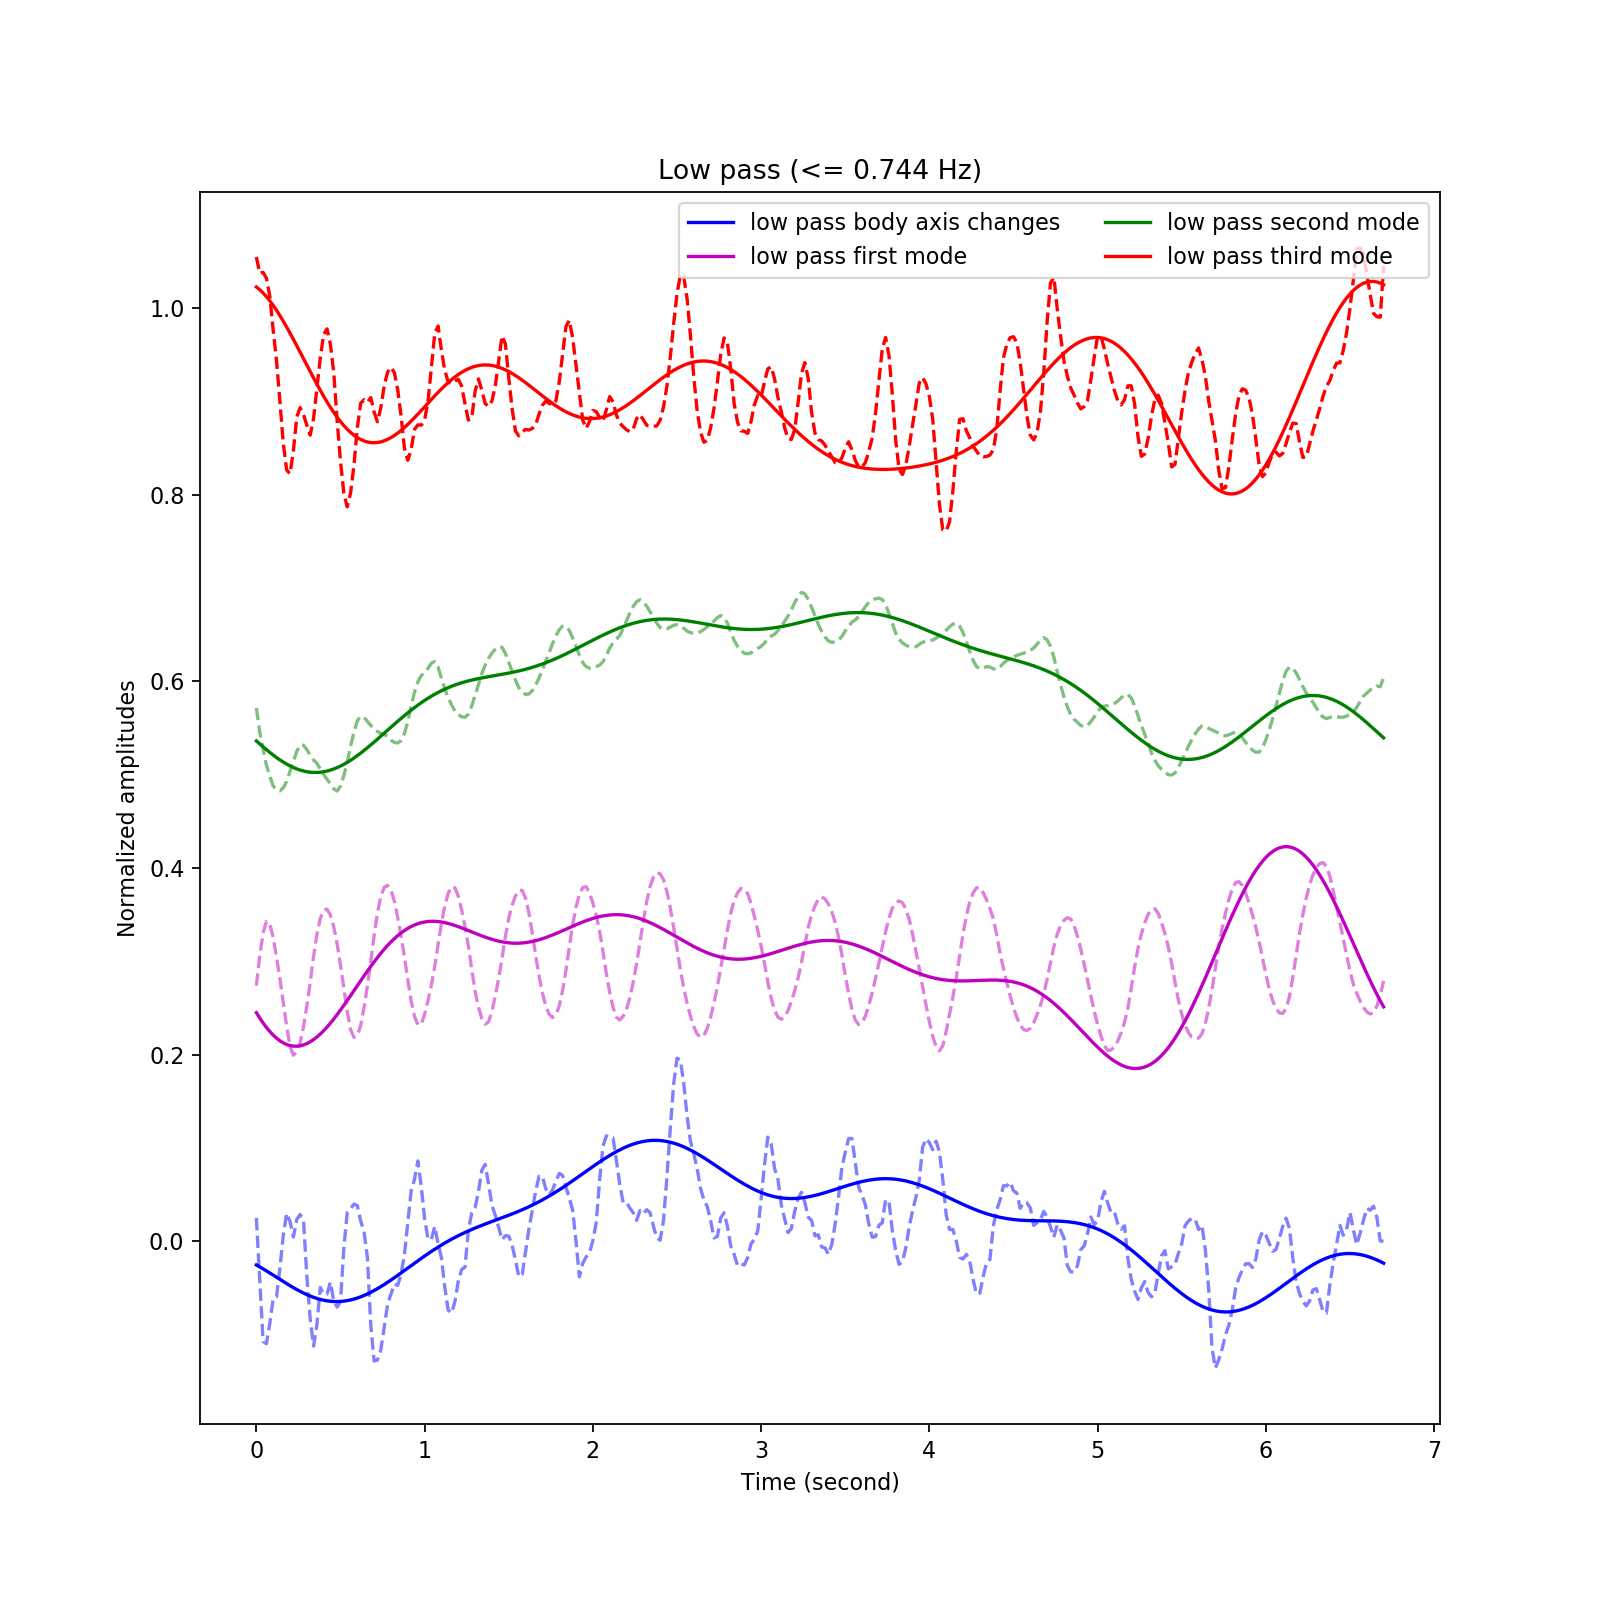

In [10]:
dt = 0.02;
# Use low band filter to get the long time scale variations in the fish bodyaxis
thres = 5/(num_frames*dt)
dtheta_low_pass = low_band_filter(dtheta, dt, thres)
Qsteer_low_pass = low_band_filter(Q_of_steer, dt, thres)
Qloco_low_pass = low_band_filter(Q_of_loco, dt, thres)
Qback_low_pass = low_band_filter(Q_of_back, dt, thres)

plt.figure(figsize=(10,10))
plt.plot(time, dtheta/np.linalg.norm(dtheta), 'b--', alpha=0.5, label='')
plt.plot(time, dtheta_low_pass/np.linalg.norm(dtheta_low_pass), 'b-', label='low pass body axis changes')

plt.plot(time, 0.3+Q_of_loco/np.linalg.norm(Q_of_loco), 'm--', alpha=0.5, label='')
plt.plot(time, 0.3+Qloco_low_pass/np.linalg.norm(Qloco_low_pass), 'm-', label='low pass first mode')

plt.plot(time, 0.6+Q_of_steer/np.linalg.norm(Q_of_steer), 'g--', alpha=0.5, label='')
plt.plot(time, 0.6+Qsteer_low_pass/np.linalg.norm(Qsteer_low_pass), 'g-', label='low pass second mode')

plt.plot(time, 0.9+Q_of_back/np.linalg.norm(Q_of_back), 'r--', label='')
plt.plot(time, 0.9+Qback_low_pass/np.linalg.norm(Qback_low_pass), 'r-', label='low pass third mode')
plt.legend(loc='upper right', ncol=2)
plt.title("Low pass (<= {:.3} Hz)".format(thres))
plt.ylabel("Normalized amplitudes")
plt.xlabel("Time (second)")
plt.savefig("low_pass_data_v{}_ind{}_tr{}.png".format(v, ind, tr), format='png')

# Which mode contributes the most to changes in direction? Now we can look at Pearson correlation coefficient betwen the low-pass filtered signals: 
* First shifting the signal around to see if that changes anything
* Second, varying the low pass threshold to see if that changes anything

<IPython.core.display.Javascript object>


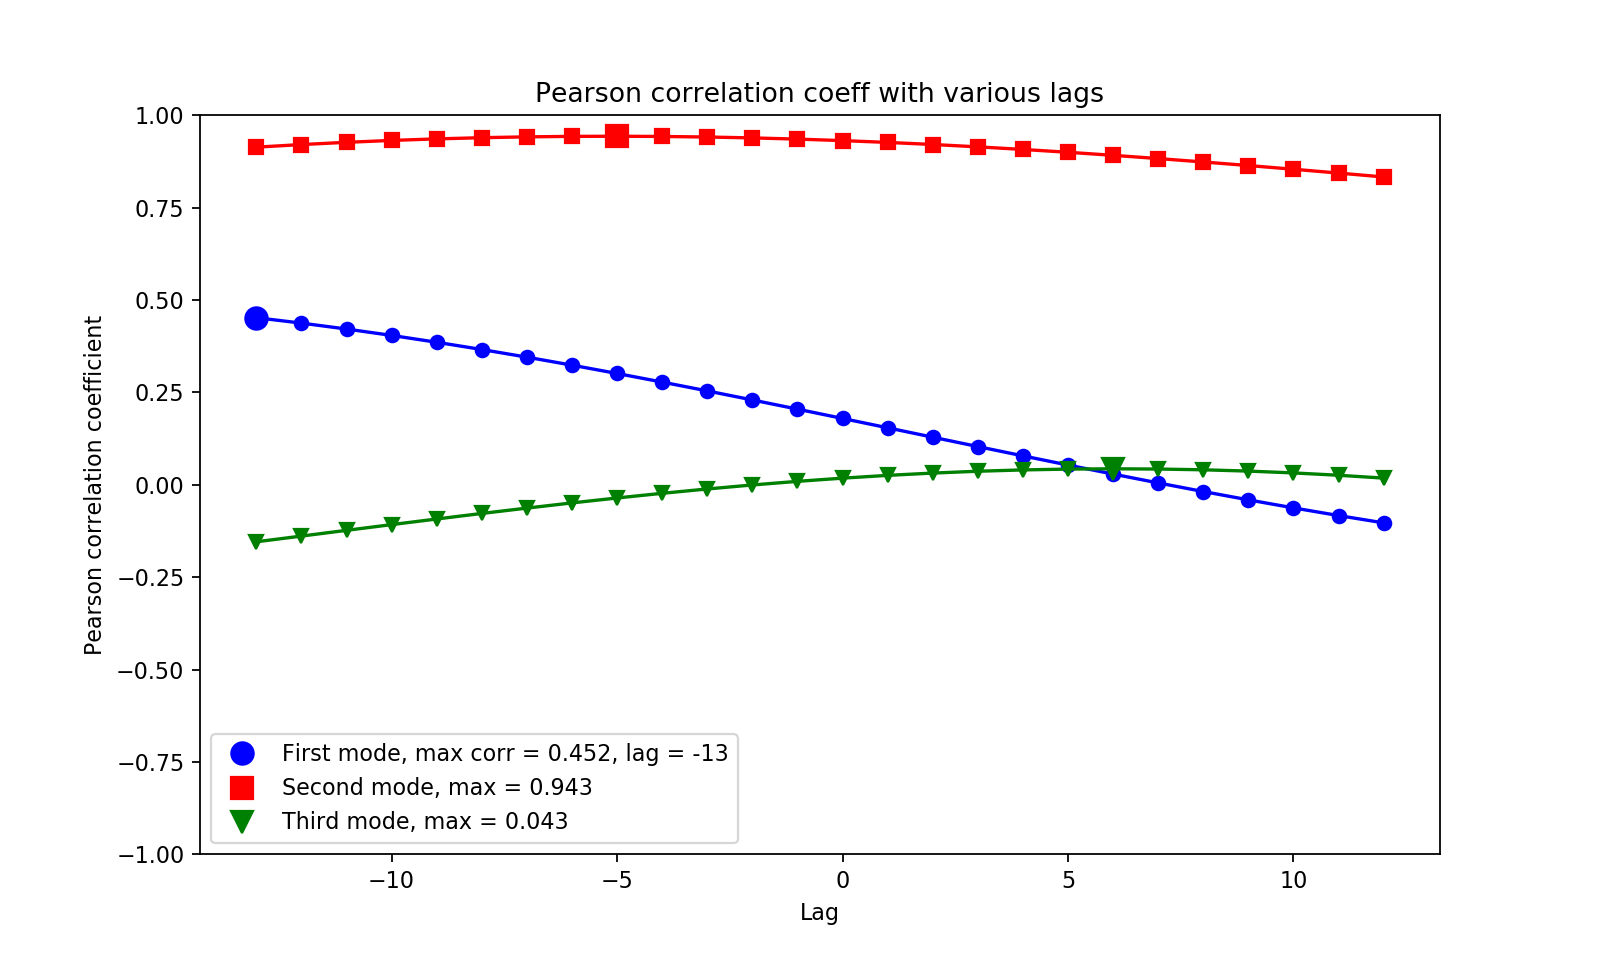

In [11]:
# Here we look at if shifting the signals around would change the correlation coefficients
max_lag = 13
loco_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qloco_low_pass), finish=None, disp=True);
st_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qsteer_low_pass), finish=None, disp=True);
back_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qback_low_pass), finish=None, disp=True);


st_coeffs = -minus_corrFunc(np.arange(-max_lag,max_lag,dtype=int), dtheta_low_pass, Qsteer_low_pass)
loco_coeffs = -minus_corrFunc(np.arange(-max_lag,max_lag,dtype=int), dtheta_low_pass, Qloco_low_pass)
back_coeffs = -minus_corrFunc(np.arange(-max_lag,max_lag,dtype=int), dtheta_low_pass, Qback_low_pass)

plt.figure(figsize=(10,6))
plt.plot(range(-max_lag,max_lag,1), loco_coeffs, 'bo-')
plt.plot([loco_res], -minus_corrFunc([loco_res], dtheta_low_pass, Qloco_low_pass), 'bo', ms=10, \
         label='First mode, max corr = {:.3f}, lag = {:d}'\
         .format(- minus_corrFunc([loco_res], dtheta_low_pass, Qloco_low_pass) [0], int(loco_res) ))


plt.plot(range(-max_lag,max_lag,1), st_coeffs, 'rs-')
plt.plot([st_res], -minus_corrFunc([st_res], dtheta_low_pass, Qsteer_low_pass), 'rs', ms=10, \
         label='Second mode, max = {:.3f}'\
         .format(-minus_corrFunc([st_res], dtheta_low_pass, Qsteer_low_pass)[0]))

plt.plot(range(-max_lag,max_lag,1), back_coeffs, 'gv-')
plt.plot([back_res], -minus_corrFunc([back_res], dtheta_low_pass, Qback_low_pass), 'gv', ms=10, \
         label='Third mode, max = {:.3f}'\
         .format(-minus_corrFunc([back_res], dtheta_low_pass, Qback_low_pass)[0]))

plt.ylim([-1,1])
plt.xlabel("Lag")
plt.ylabel("Pearson correlation coefficient")
plt.title("Pearson correlation coeff with various lags")
plt.legend()

<IPython.core.display.Javascript object>


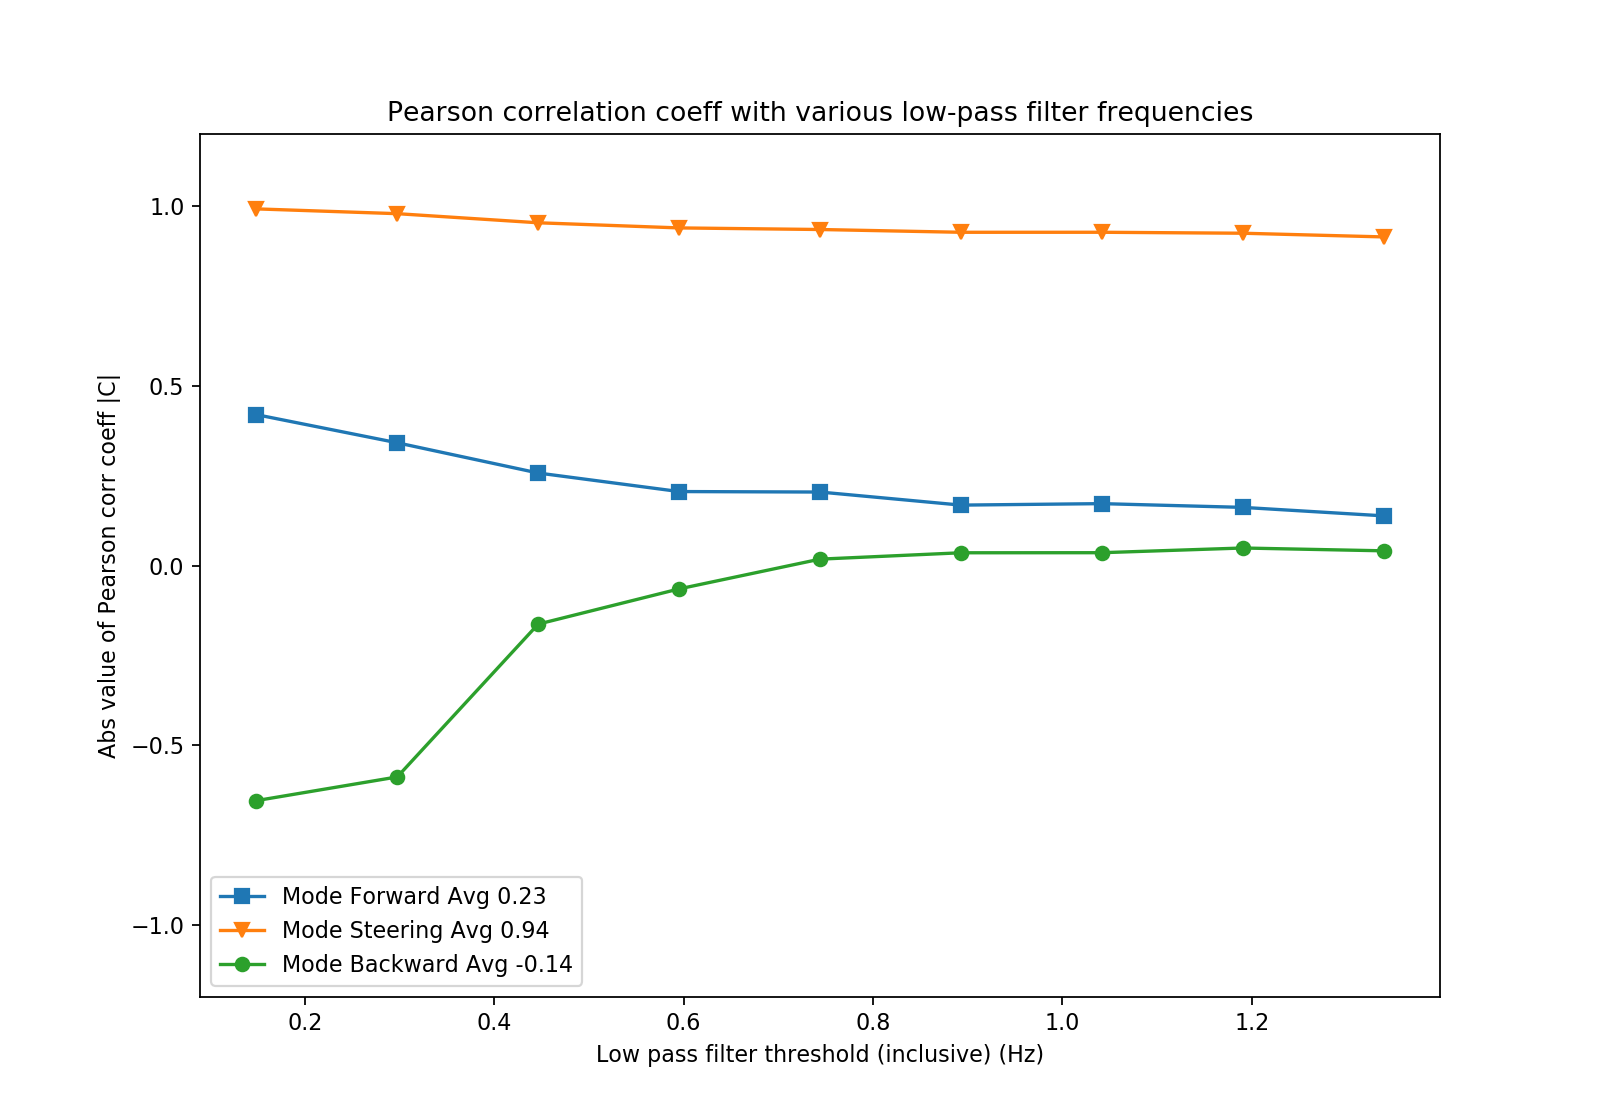

Text(0.5, 1.0, 'Pearson correlation coeff with various low-pass filter frequencies')

In [12]:
thresholds = np.arange(1, 10)/(len(dtheta)*dt)
max_lag = 1 # This basically says no lag is applied
modes = ['Forward', 'Steering', 'Backward']

corrs = np.zeros((len(thresholds), 3))

for i  in range(len(thresholds)):
    thres=thresholds[i]

    dtheta_low_pass = low_band_filter(dtheta, dt, thres)
    Qsteer_low_pass = low_band_filter(Q_of_steer, dt, thres)
    Qloco_low_pass = low_band_filter(Q_of_loco, dt, thres)
    Qback_low_pass = low_band_filter(Q_of_back, dt, thres)


    loco_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qloco_low_pass), finish=None, disp=True);
    st_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qsteer_low_pass), finish=None, disp=True);
    back_res = brute(minus_corrFunc, (slice(-max_lag,max_lag,1),), args=(dtheta_low_pass, Qback_low_pass), finish=None, disp=True);
    corrs[i] = np.array([-minus_corrFunc([loco_res], dtheta_low_pass, Qloco_low_pass)[0], \
               -minus_corrFunc([st_res], dtheta_low_pass, Qsteer_low_pass)[0], \
               -minus_corrFunc([back_res], dtheta_low_pass, Qback_low_pass)[0]])

# Visualize the correlation coefficients we just computed
plt.figure(figsize=(10,7))
plt.ylim([-1.2,1.2])
markers=['s', 'v', 'o']
for i in range(3):
    plt.plot(thresholds, corrs[:,i], marker=markers[i], label='Mode {} Avg {:.2f}'.format(modes[i], np.mean(corrs[:,i])))
plt.legend()
plt.ylabel("Abs value of Pearson corr coeff |C|")
plt.xlabel("Low pass filter threshold (inclusive) (Hz)")
plt.title("Pearson correlation coeff with various low-pass filter frequencies")
# plt.savefig("low_pass_correlation_v{}_ind{}_tr{}.png".format(v, ind, tr), format='png')